In [1]:
import torch
import torch.nn as nn 
import torchvision as tv
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os 
import torch.utils.data
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import albumentations as A 
from albumentations.pytorch import ToTensorV2
import pycocotools
from random import shuffle
import csv
from collections import defaultdict
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
with_checkpoint = False

In [2]:
def get_model(num_classes):
    model = tv.models.maxvit_t(weights=tv.models.MaxVit_T_Weights.DEFAULT)
    model.classifier[-1] = nn.Linear(512, num_classes, bias=False)
    return model

In [3]:
model = get_model(num_classes=3)
checkpoint_epoch = 1
if with_checkpoint:
    checkpoint = torch.load('maxvit2.pth', map_location=device)
    checkpoint_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint["model_state_dict"])
    
model = model.to(device)

/home/andrey/work/jupiter/venv/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
def print_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.3f}MB'.format(size_all_mb))

In [5]:
print_model_size(model)

model size: 116.587MB


In [6]:
def get_train_transforms():
    return A.Compose([
        A.Blur(
            blur_limit=3,
            p=0.1
        ),
        A.MotionBlur(
            blur_limit=3,
            p=0.1
        ),
        A.MedianBlur(
            blur_limit=3,
            p=0.1,
        ),
        A.ToGray(
            p=0.3,
        ),
        A.RandomBrightnessContrast(
            p=0.3,
        ),
        A.ColorJitter(
            p=0.3,
        ),
        A.RandomGamma(
            p=0.3,
        ),
        ToTensorV2(p=1.0)]
    )
def get_test_transforms():
    return A.Compose([ToTensorV2(p=1)])

In [7]:
class GazeDataset(torch.utils.data.Dataset):
    def __init__(self, dir, dir_list, meta, size, transforms=None):
        super().__init__()
        self.transforms = transforms
        self.dir = dir
        self.width, self.height = size
        self.dir_list = dir_list
        self.meta = meta
    def __len__(self):
        return len(self.dir_list)
    def __getitem__(self, index):
        img_file = self.dir_list[index]
        img = cv2.imread(os.path.join(self.dir, *img_file), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_width = img.shape[1]
        img_height = img.shape[0]
        img = img.astype(np.float32)/255.
        img = cv2.resize(img, (self.width, self.height), interpolation=cv2.INTER_AREA)
        t_img = img.transpose((2, 0, 1))
        t_img = torch.from_numpy(img)
        labels = self.meta.index(img_file[1])
        t_labels = labels
        if self.transforms:
            sample = self.transforms(image=img)
            t_img = sample['image']
        
        
        return t_img, t_labels

In [8]:
def create_datasets(dir, meta, size, train_transforms=None, test_transforms=None):
    dir_list = [file for file in os.listdir(dir) 
                if os.path.splitext(file)[1] in ['.jpg', '.png']]
    train_list = []
    test_list = []
    for cla in meta:
        train_list += [('train', cla, file) for file in os.listdir(os.path.join(dir, 'train', cla)) 
                       if os.path.splitext(file)[1] in ['.jpg', '.png']]
    for cla in meta:
        test_list += [('test', cla, file) for file in os.listdir(os.path.join(dir, 'test', cla)) 
                       if os.path.splitext(file)[1] in ['.jpg', '.png']]
    
    return GazeDataset(dir, train_list, meta, size, train_transforms), GazeDataset(dir, test_list,meta, size, test_transforms)

In [9]:
train_data, test_data = create_datasets('gaze2', ['face', 'side_left', 'side_right'], (224, 224), get_train_transforms(), get_test_transforms())
print(len(train_data))
print(len(test_data))

5901
468


In [10]:
batch_size = 4
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True,
    num_workers=1, drop_last=False
)
valid_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False,
    num_workers=1, drop_last=False
)

In [11]:
optimizer = torch.optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()
if with_checkpoint:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    criterion = checkpoint['loss']
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

In [12]:
class SaveBestModel:
    def __init__(
        self, best_valid=float(0)
    ):
        self.best_valid = best_valid
        
    def __call__(
        self, 
        model, 
        current_valid, 
        epoch
    ):
        if current_valid > self.best_valid:
            self.best_valid = current_valid
            print(f"\nBEST VALIDATION: {self.best_valid}")
            print(f"\nSAVING BEST MODEL FOR EPOCH: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                }, "best_maxvit2_model.pth")

In [13]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"maxvit2.pth")

def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"accuracy2.png")
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"maxvit_loss2.png")

In [14]:
def train_one_epoch(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [15]:
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [16]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
epochs = 100
savebestmodel = SaveBestModel()
for epoch in range(checkpoint_epoch-1, epochs+checkpoint_epoch-1):
    print(f"[INFO]: Epoch {epoch+1} of {epochs+checkpoint_epoch-1}")
    train_epoch_loss, train_epoch_acc = train_one_epoch(model, train_loader, 
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    savebestmodel(model, valid_epoch_acc, epoch)
    scheduler.step(valid_epoch_acc)
    print(f'Lr: {scheduler.get_last_lr()}')

[INFO]: Epoch 1 of 100
Training


100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:58<00:00,  4.95it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.46it/s]


Training loss: 0.301, training acc: 89.137
Validation loss: 0.384, validation acc: 85.897
--------------------------------------------------

BEST VALIDATION: 85.8974358974359

SAVING BEST MODEL FOR EPOCH: 1

Lr: [0.001]
[INFO]: Epoch 2 of 100
Training


100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:53<00:00,  5.03it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.69it/s]


Training loss: 0.157, training acc: 95.238
Validation loss: 0.212, validation acc: 93.803
--------------------------------------------------

BEST VALIDATION: 93.80341880341881

SAVING BEST MODEL FOR EPOCH: 2

Lr: [0.001]
[INFO]: Epoch 3 of 100
Training


100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:52<00:00,  5.05it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.00it/s]


Training loss: 0.112, training acc: 96.441
Validation loss: 0.107, validation acc: 96.581
--------------------------------------------------

BEST VALIDATION: 96.58119658119658

SAVING BEST MODEL FOR EPOCH: 3

Lr: [0.001]
[INFO]: Epoch 4 of 100
Training


100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:50<00:00,  5.08it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.36it/s]

Training loss: 0.116, training acc: 96.373
Validation loss: 0.267, validation acc: 93.803
--------------------------------------------------
Lr: [0.001]
[INFO]: Epoch 5 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:51<00:00,  5.07it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.12it/s]

Training loss: 0.095, training acc: 97.136
Validation loss: 0.111, validation acc: 96.581
--------------------------------------------------
Lr: [0.001]
[INFO]: Epoch 6 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:52<00:00,  5.05it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.47it/s]

Training loss: 0.081, training acc: 97.729
Validation loss: 0.128, validation acc: 96.154
--------------------------------------------------
Lr: [0.001]
[INFO]: Epoch 7 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:50<00:00,  5.09it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.04it/s]

Training loss: 0.090, training acc: 97.407
Validation loss: 0.101, validation acc: 96.581
--------------------------------------------------
Lr: [0.0001]
[INFO]: Epoch 8 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:53<00:00,  5.03it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.50it/s]


Training loss: 0.035, training acc: 99.102
Validation loss: 0.101, validation acc: 97.222
--------------------------------------------------

BEST VALIDATION: 97.22222222222221

SAVING BEST MODEL FOR EPOCH: 8

Lr: [0.0001]
[INFO]: Epoch 9 of 100
Training


100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:50<00:00,  5.09it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 14.95it/s]


Training loss: 0.025, training acc: 99.424
Validation loss: 0.077, validation acc: 98.077
--------------------------------------------------

BEST VALIDATION: 98.07692307692307

SAVING BEST MODEL FOR EPOCH: 9

Lr: [0.0001]
[INFO]: Epoch 10 of 100
Training


100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:55<00:00,  4.99it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.59it/s]

Training loss: 0.023, training acc: 99.576
Validation loss: 0.091, validation acc: 97.222
--------------------------------------------------
Lr: [0.0001]
[INFO]: Epoch 11 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:49<00:00,  5.11it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.15it/s]


Training loss: 0.022, training acc: 99.559
Validation loss: 0.061, validation acc: 98.504
--------------------------------------------------

BEST VALIDATION: 98.50427350427351

SAVING BEST MODEL FOR EPOCH: 11

Lr: [0.0001]
[INFO]: Epoch 12 of 100
Training


100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:54<00:00,  5.01it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.52it/s]

Training loss: 0.018, training acc: 99.627
Validation loss: 0.062, validation acc: 98.291
--------------------------------------------------
Lr: [0.0001]
[INFO]: Epoch 13 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:49<00:00,  5.09it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.43it/s]

Training loss: 0.014, training acc: 99.746
Validation loss: 0.067, validation acc: 98.504
--------------------------------------------------
Lr: [0.0001]
[INFO]: Epoch 14 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:54<00:00,  5.01it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.52it/s]

Training loss: 0.018, training acc: 99.610
Validation loss: 0.064, validation acc: 98.504
--------------------------------------------------
Lr: [0.0001]
[INFO]: Epoch 15 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:48<00:00,  5.11it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.29it/s]

Training loss: 0.012, training acc: 99.729
Validation loss: 0.093, validation acc: 97.650
--------------------------------------------------
Lr: [1e-05]
[INFO]: Epoch 16 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:54<00:00,  5.01it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.14it/s]

Training loss: 0.013, training acc: 99.695
Validation loss: 0.078, validation acc: 98.077
--------------------------------------------------
Lr: [1e-05]
[INFO]: Epoch 17 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:48<00:00,  5.11it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.36it/s]

Training loss: 0.012, training acc: 99.729
Validation loss: 0.081, validation acc: 97.863
--------------------------------------------------
Lr: [1e-05]
[INFO]: Epoch 18 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:52<00:00,  5.05it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.47it/s]

Training loss: 0.012, training acc: 99.746
Validation loss: 0.080, validation acc: 98.077
--------------------------------------------------
Lr: [1e-05]
[INFO]: Epoch 19 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:48<00:00,  5.12it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.53it/s]

Training loss: 0.010, training acc: 99.814
Validation loss: 0.081, validation acc: 98.077
--------------------------------------------------
Lr: [1.0000000000000002e-06]
[INFO]: Epoch 20 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:53<00:00,  5.02it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.39it/s]

Training loss: 0.010, training acc: 99.797
Validation loss: 0.081, validation acc: 98.077
--------------------------------------------------
Lr: [1.0000000000000002e-06]
[INFO]: Epoch 21 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:48<00:00,  5.12it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.20it/s]

Training loss: 0.010, training acc: 99.831
Validation loss: 0.081, validation acc: 98.077
--------------------------------------------------
Lr: [1.0000000000000002e-06]
[INFO]: Epoch 22 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:54<00:00,  5.02it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.29it/s]

Training loss: 0.010, training acc: 99.814
Validation loss: 0.082, validation acc: 98.077
--------------------------------------------------
Lr: [1.0000000000000002e-06]
[INFO]: Epoch 23 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:48<00:00,  5.12it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.34it/s]

Training loss: 0.010, training acc: 99.831
Validation loss: 0.081, validation acc: 98.077
--------------------------------------------------
Lr: [1.0000000000000002e-07]
[INFO]: Epoch 24 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:54<00:00,  5.02it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.46it/s]

Training loss: 0.009, training acc: 99.864
Validation loss: 0.082, validation acc: 98.077
--------------------------------------------------
Lr: [1.0000000000000002e-07]
[INFO]: Epoch 25 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:49<00:00,  5.10it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.53it/s]

Training loss: 0.009, training acc: 99.780
Validation loss: 0.082, validation acc: 98.077
--------------------------------------------------
Lr: [1.0000000000000002e-07]
[INFO]: Epoch 26 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:53<00:00,  5.02it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.24it/s]

Training loss: 0.010, training acc: 99.797
Validation loss: 0.081, validation acc: 98.077
--------------------------------------------------
Lr: [1.0000000000000002e-07]
[INFO]: Epoch 27 of 100
Training



100%|██████████████████████████████████████████████████████████████████████████████| 1476/1476 [04:50<00:00,  5.08it/s]

Validation



100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.13it/s]

Training loss: 0.010, training acc: 99.831
Validation loss: 0.082, validation acc: 98.077
--------------------------------------------------
Lr: [1.0000000000000004e-08]
[INFO]: Epoch 28 of 100
Training



 36%|████████████████████████████▋                                                  | 537/1476 [01:46<03:05,  5.05it/s]


KeyboardInterrupt: 

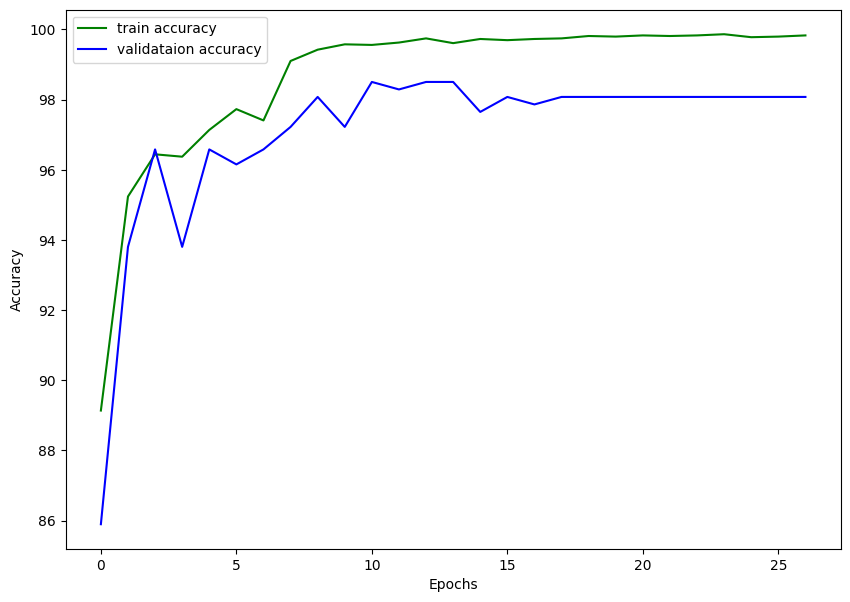

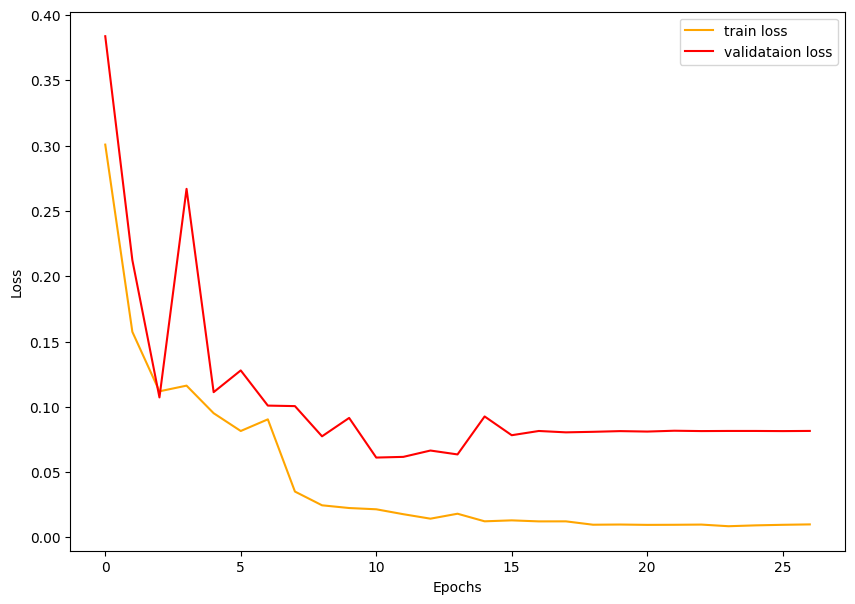

In [17]:
save_model(epoch, model, optimizer, criterion)
save_plots(train_acc, valid_acc, train_loss, valid_loss)